In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset
from modelval.ArbDataGen import arb_w_gen

% matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
trip_para = pd.read_pickle('/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]
trip_para

A2_+     A3_-    A2_-    A3_+ Tau_+ Tau_x Tau_-  \
Visu_AlltoAll    Full    5e-10  0.00023   0.007  0.0062  16.8   101  33.7   
                 Min         0        0  0.0071  0.0065  16.8     1  33.7   
Visu_NearestSpk  Full  8.8e-11   0.0031  0.0066   0.053  16.8   714  33.7   
                 Min         0        0   0.008    0.05  16.8     1  33.7   
Hippo_AlltoAll   Full   0.0061   0.0014  0.0016  0.0067  16.8   946  33.7   
                 Min    0.0053        0  0.0035   0.008  16.8     1  33.7   
Hippo_NearestSpk Full   0.0046  7.5e-09   0.003  0.0091  16.8   575  33.7   
                 Min    0.0046        0   0.003  0.0091  16.8     1  33.7   

                      Tau_y  
Visu_AlltoAll    Full   125  
                 Min    114  
Visu_NearestSpk  Full    40  
                 Min     40  
Hippo_AlltoAll   Full    27  
                 Min     40  
Hippo_NearestSpk Full    47  
                 Min     48

1.0 1.0 1.0


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


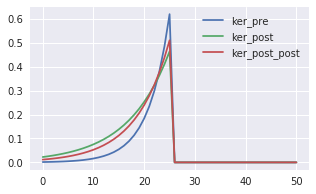

In [104]:
# Visualize kernel
from modelval.kernel import KernelGen
plt.figure(figsize=(5,3))
ker_test = KernelGen()

para = trip_para.loc[('Hippo_AlltoAll', 'Full'), :]
ker_test = KernelGen(len_kernel=51)
ker_test.trip_model_ker(para, data_name='Hippocampus')
ker_test.kernel_scale = ker_test.kernel_scale[:2]

plt.plot(ker_test.kernel_pre, label='ker_pre')
plt.plot(ker_test.kernel_post, label='ker_post')
plt.plot(ker_test.kernel_post_post, label='ker_post_post')

plt.legend()
print(np.linalg.norm(ker_test.kernel_pre, ord=2), np.linalg.norm(ker_test.kernel_post, ord=2), np.linalg.norm(ker_test.kernel_post_post, ord=2))

In [105]:
ker_test.kernel_scale

array([ 0.00983431,  0.00344706])

In [106]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data['train_len'] = data['ptl_occ'] / data['ptl_freq']
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60.0
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60.0
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60.0
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60.0
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60.0


In [107]:
# Generate data
ptl_list = [1]
data_select = data[data['ptl_idx'].isin(ptl_list)]

# Insert values for STDP
dt = np.arange(-100,100,2)
for i in range(len(dt)):
    new_try1 = data[data['ptl_idx']==1].iloc[0]
    new_try1['dt1'] = dt[i]
    data_select = data_select.append(new_try1, ignore_index=True)
        
spk_len = int(data[data['ptl_idx'].isin(ptl_list)]['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, targets = arb_w_gen(df=data_select, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[10], net_type='pair')

In [108]:
# Create the network
ground_truth_init = 0
reg_scale = (0,0)
toy_data_net2 = network.PairNet(kernel=ker_test, ground_truth_init=ground_truth_init, reg_scale=reg_scale, n_input=spk_pairs.shape[1])

In [109]:
# Create the trainer
save_dir= '/src/Plasticity_Ker/model/PairNet_ptl1_toy'
toy_net2_trainer = trainer.Trainer(toy_data_net2.mse, toy_data_net2.loss, input_name=toy_data_net2.inputs, target_name=toy_data_net2.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net2.lr})

In [110]:
# Obtain the training and validation data
from sklearn.model_selection import train_test_split

X_train, X_vali, y_train, y_vali = train_test_split(spk_pairs, targets, test_size=0.1)
train_data = dataset.Dataset(X_train, y_train)
vali_data = dataset.Dataset(X_vali, y_vali)

array([ 0.43783796,  0.52456045], dtype=float32)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


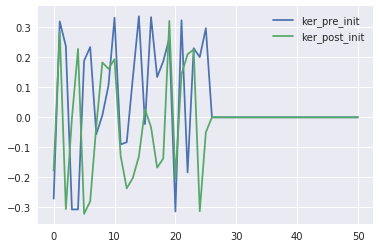

In [111]:
w_pre = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_pre)
w_post = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_post)
fc_w = toy_net2_trainer.evaluate(ops=toy_data_net2.fc_w)
plt.plot(w_pre,  label='ker_pre_init')
plt.plot(w_post,  label='ker_post_init')
plt.legend()
fc_w

In [116]:
# Learn the kernel from random initialization
learning_rate = 0.001
iterations = 5
min_error = -1
for i in range(iterations):
    toy_net2_trainer.train(train_data, vali_data, batch_size=128, min_error=min_error, feed_dict={toy_data_net2.lr: learning_rate})
    learning_rate = learning_rate/3

Global Step 2000 and Step 0012: validation cost=0.22585
Updated min validation loss!Saving model...
Global Step 2050 and Step 0062: validation cost=0.20301
Updated min validation loss!Saving model...
Global Step 2100 and Step 0112: validation cost=0.18223
Updated min validation loss!Saving model...
Global Step 2150 and Step 0162: validation cost=0.16321
Updated min validation loss!Saving model...
Global Step 2200 and Step 0212: validation cost=0.14554
Updated min validation loss!Saving model...
Global Step 2250 and Step 0262: validation cost=0.13025
Updated min validation loss!Saving model...
Global Step 2300 and Step 0312: validation cost=0.11553
Updated min validation loss!Saving model...
Global Step 2350 and Step 0362: validation cost=0.10212
Updated min validation loss!Saving model...
Global Step 2400 and Step 0412: validation cost=0.09051
Updated min validation loss!Saving model...
Global Step 2450 and Step 0462: validation cost=0.07982
Updated min validation loss!Saving model...


KeyboardInterrupt: 

array([ 0.43783796,  0.52456045], dtype=float32)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


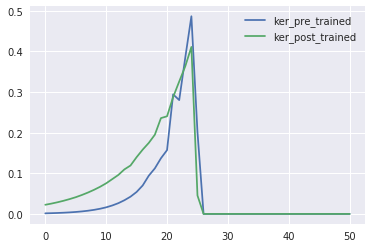

In [117]:
toy_net2_trainer.restore_best()
w_pre = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_pre)
w_post = toy_net2_trainer.evaluate(ops=toy_data_net2.kernel_post)
fc_w = toy_net2_trainer.evaluate(ops=toy_data_net2.fc_w)
plt.plot(w_pre,  label='ker_pre_trained')
plt.plot(w_post,  label='ker_post_trained')
plt.legend()
fc_w

In [ ]:
kernel_scale